## Analyzing ~90 gb Ad clicks data using Spark2.1, pandas and SQL/Hive

In this notebook, I leverage the power of a Spark cluster to explore the large (~90 GB) page_views.csv dataset and analyze its relationshiop with events.csv in the Kaggle - Outbrain Click Prediction challenge .
We answer questions like: <br>
- How to join page_views.csv and events.csv?<br>
- Is events.csv a subset of page_views.csv?<br>
- Are there additional page views for users in events.csv?<br>


## Dependencies
pySpark 2.1
Pandas and Matplotlib - Only on master node <br>

In [1]:
import findspark
findspark.init()

In [2]:
findspark.find()

'/Users/mudy/programming/2016/spark-2.1.0-bin-hadoop2.7'

In [3]:
#import pyspark

In [3]:
from pyspark.sql import *
#dir(pyspark.sql)

In [5]:
from pyspark.sql.types import *
import pyspark.sql.functions as F

## Analyzing page views

In [4]:
spark = (SparkSession.builder\
                    .master("local[*]")\
                    #.config("spark.sql.warehouse.dir", "target/spark-warehouse")\
                    .appName("Ad analysis")\
                    .enableHiveSupport()\
                    .getOrCreate())

In [6]:
spark.sparkContext.defaultParallelism

8

### Reading file from hadoop/hdfs/local-fs

In [7]:
page_views_schema = StructType(
                    [StructField("uuid", StringType(), True),
                    StructField("document_id", IntegerType(), True),
                    StructField("timestamp", IntegerType(), True),
                    StructField("platform", IntegerType(), True),
                    StructField("geo_location", StringType(), True),
                    StructField("traffic_source", IntegerType(), True)]
                    )

page_views_df = (spark.read.schema(page_views_schema)
                 .options(header='true', inferschema='false', nullValue='\\N')
                .csv("data/page_views.csv")) #.csv("hdfs:<path>")

### See first 10 rows

In [8]:
page_views_df.show(10)

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
|2aa611f32875c7|        120| 71495491|       1|       CA>ON|             2|
|f55a6eaf2b34ab|        120| 73309199|       1|       BR>27|             2|
|cc01b582c8cbff|        120| 50033577|       1|       CA>BC|             2|
|6c802978b8dd4d|        120| 66590306|       1|       CA>ON|             2|
|f4e423314303ff|        120| 48314254|       1|   US>LA>622|             1|
+-----------

```
page_views.csv is a the log of users visiting documents. To save disk space, the timestamps in the entire dataset are relative to the first time in the dataset. If you wish to recover the actual epoch time of the visit, add 1465876799998 to the timestamp.

    uuid
    document_id
    timestamp (ms since 1970-01-01 - 1465876799998)
    platform (desktop = 1, mobile = 2, tablet =3)
    geo_location (country>state>DMA)
    traffic_source (internal = 1, search = 2, social = 3)
```

In [31]:
page_views_df.rdd.getNumPartitions()

15

In [32]:
%time page_views_df.count() # 43 mil vs 10 mil

CPU times: user 1.62 ms, sys: 991 µs, total: 2.61 ms
Wall time: 9.91 s


43372073

In [9]:
%time page_views_timestamp_stats_df = page_views_df.describe('timestamp')

CPU times: user 2.87 ms, sys: 1.46 ms, total: 4.34 ms
Wall time: 11.6 s


In [10]:
page_views_timestamp_stats = page_views_timestamp_stats_df.rdd.collectAsMap()
page_views_timestamp_stats

{u'count': u'43372073',
 u'max': u'86399997',
 u'mean': u'4.90901847661637E7',
 u'min': u'0',
 u'stddev': u'2.2688274972918767E7'}

In [11]:
page_views_count = int(page_views_timestamp_stats['count'])
page_views_count

43372073

### Understanding date ranges & time

We can see below that dataset contains only page views between 2016-06-14 and 2016-06-28. As min and max timestamp in dataset are at about 4am, it suggests that dates are in UTC and the dataset days were filtered according to UTC-4 (Eastern Time - EST)...<br>
To further model users preferences, it would be nice if we had in this dataset the full log of previous users pages visits, who had at least an event between that period (2016-06-14 and 2016-06-28).

In [37]:
from datetime import datetime
def convert_odd_timestamp(timestamp_ms_relative):
    TIMESTAMP_DELTA=1465876799998
    return datetime.fromtimestamp((int(timestamp_ms_relative)+TIMESTAMP_DELTA)//1000)

In [38]:
print convert_odd_timestamp(page_views_timestamp_stats['min'])

2016-06-13 20:59:59


In [39]:
print convert_odd_timestamp(page_views_timestamp_stats['max'])

2016-06-14 20:59:59


## page views by user

In [40]:
import pandas as pd

In [12]:
#grouping page views by user and counting
page_views_by_user = page_views_df.groupBy('uuid').count()
# now we have "uuid_1 -> view_count"

In [13]:
# see distribution of page_views
page_views_by_user_distribution = page_views_by_user.select('count').groupby('count').count()

In [14]:
#convert spark df -> pandas df for plotting
%time page_views_by_user_pd = page_views_by_user_distribution.toPandas()

CPU times: user 174 ms, sys: 74.4 ms, total: 248 ms
Wall time: 38 s


In [ ]:
len(page_views_by_user)

In [15]:
page_views_by_user_pd.columns = ['pageViewsByUser','userCount']
page_views_by_user_pd = page_views_by_user_pd.set_index('pageViewsByUser').sort_index()
page_views_by_user_pd.head()

,userCount
pageViewsByUser,
1,27719026
2,3890866
3,1104428
4,422917
5,191517


### Distinct users count

In [41]:
distinct_users = page_views_by_user_pd.userCount.sum()
distinct_users

33568779

### Average page views by users

In [17]:
avg_page_views_user = page_views_count / float(distinct_users)
avg_page_views_user

1.2920360612460764

In [23]:
import seaborn as sns
%matplotlib inline

In [37]:
page_views_by_user_pd.describe()

,userCount
count,3.900000e+01
mean,8.607379e+05
std,4.460463e+06
min,1.000000e+00
25%,1.950000e+01
50%,3.890000e+02
75%,1.138350e+04
max,2.771903e+07


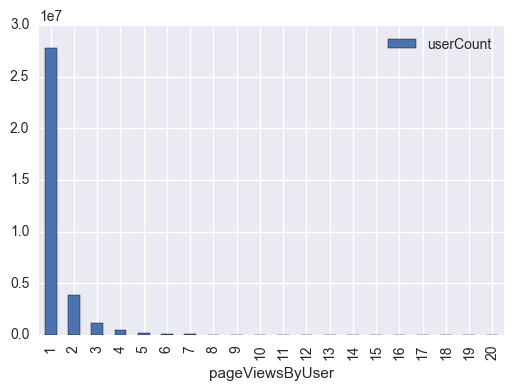

In [28]:
page_views_by_user_pd.head(20).plot.bar(y='userCount')

#### the cumulative percentual of users with at most N page views

In [45]:
page_views_by_user_pd['cum_perc_UserCount'] = (page_views_by_user_pd['userCount'].cumsum()/distinct_users) * 100

In [48]:
page_views_by_user_pd.head(8)
#page_views_by_user_pd.drop('cumUserCount', axis = 1, inplace=True)

,userCount,cum_perc_UserCount
pageViewsByUser,,
1,27719026,82.573828
2,3890866,94.164557
3,1104428,97.454602
4,422917,98.714454
5,191517,99.284975
6,94670,99.566993
7,51054,99.719081
8,29116,99.805817


We see that 80% of users have 1 page views, 94% have atmost 2 page views etc.. Let
s plot this. 

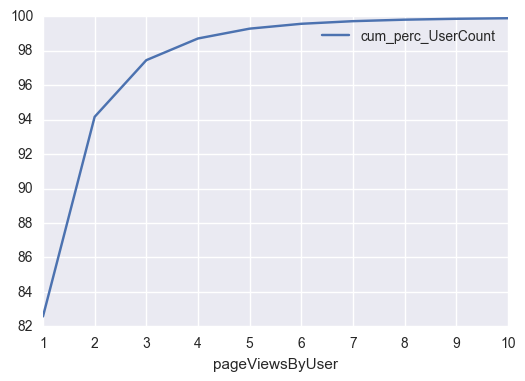

In [49]:
page_views_by_user_pd.head(10).plot.line(y='cum_perc_UserCount')

### Page views by platform

In [51]:
page_views_by_platform_pd = page_views_df.groupBy('platform').count().toPandas()

In [58]:
page_views_by_platform_pd = page_views_by_platform_pd.set_index('platform').sort_index()
page_views_by_platform_pd

,count
platform,
1,18002054
2,21648449
3,3721570


### Distribution of page views by platform

In [56]:
import plotly
plotly.__version__
plotly.tools.set_credentials_file(username='modqhx', api_key='PcHq63cYg47FcTsU7Uwx')

In [60]:
labels = ['Desktop(1)', 'Mobile(2)', 'Tablet(3)']
trace=go.Pie(labels=labels,values=page_views_by_platform_pd['count'])
py.iplot([trace])

## Distribution of page views by platform

In [74]:
%time page_views_by_traffic_pd = page_views_df.groupBy('traffic_source').count().toPandas()

CPU times: user 4.73 ms, sys: 3.25 ms, total: 7.98 ms
Wall time: 10.3 s


In [77]:
page_views_by_traffic_pd

,traffic_source,count
0,1,28200084
1,3,7846185
2,2,7325804


In [83]:
labels = ['Internal(1)', 'Search(2)', 'Social(3)']
trace=go.Pie(labels=labels,values=page_views_by_traffic_pd['count'])
py.iplot([trace])

### Users visting more than once

Numbers of users visiting a page more than once = 

In [93]:
page_views_by_user_doc = page_views_df.groupBy(['uuid', 'document_id']).count().alias('count')

In [94]:
page_views_by_user_doc.show(10)

+--------------+-----------+-----+
|          uuid|document_id|count|
+--------------+-----------+-----+
|99bb9fcf17e45f|       7012|    1|
|39d4b575dba176|       7012|    1|
|efae046385ebbd|       7012|    1|
|7ff3b97075df96|       7012|    1|
|6350f38ceb9190|       7702|    1|
|e1000356d14f9a|      10653|    1|
|ccff60dcc4bf10|      14343|    1|
|964a2ba483f7d2|      22181|    1|
|9fd54bcdc2579e|      25345|    1|
|aae6099cb0c2ca|      25529|    1|
+--------------+-----------+-----+
only showing top 10 rows



----

# Joining data with events

In [95]:
events_schema = StructType(
                    [StructField("display_id", IntegerType(), True),
                    StructField("uuid", StringType(), True),
                    StructField("document_id", IntegerType(), True),
                    StructField("timestamp", IntegerType(), True),
                    StructField("platform", IntegerType(), True),
                    StructField("geo_location", StringType(), True)]
                    )

events_df = spark.read \
            .schema(events_schema) \
            .options(header='true', inferschema='false', nullValue='\\N') \
            .csv("data/events.csv")

In [96]:
events_df.rdd.getNumPartitions()

10

In [97]:
events_df.show(10)

+----------+--------------+-----------+---------+--------+------------+
|display_id|          uuid|document_id|timestamp|platform|geo_location|
+----------+--------------+-----------+---------+--------+------------+
|         1|cb8c55702adb93|     379743|       61|       3|   US>SC>519|
|         2|79a85fa78311b9|    1794259|       81|       2|   US>CA>807|
|         3|822932ce3d8757|    1179111|      182|       2|   US>MI>505|
|         4|85281d0a49f7ac|    1777797|      234|       2|   US>WV>564|
|         5|8d0daef4bf5b56|     252458|      338|       2|       SG>00|
|         6|7765b4faae4ad4|    1773517|      395|       3|   US>OH>510|
|         7|2cc3f6457d16da|    1149661|      602|       2|   US>MT>762|
|         8|166fc654d73c98|    1330329|      638|       2|   US>PA>566|
|         9|9dddccf70f6067|    1772126|      667|       1|   US>FL>528|
|        10|b09a0e92aa4d17|     157455|      693|       1|          US|
+----------+--------------+-----------+---------+--------+------

In [114]:
%time events_count = events_df.count()

CPU times: user 1.15 ms, sys: 722 µs, total: 1.87 ms
Wall time: 6.25 s


### Distinct users

In [113]:
distinct_event_users = events_df.agg(F.countDistinct("uuid").alias('count')).collect()[0]['count']

In [105]:
distinct_event_users

19794967

### Average events by user

In [117]:
avg_events_by_user = events_count / float(distinct_event_users)
avg_events_by_user

1.1679800223966021

### Create dummy variables for joining datasets